In [114]:
from procesador_votaciones import ProcesadorDeVotaciones
from heavy_graph_maker import HeavyGraphMaker

In [182]:
year = 2018
procesador = ProcesadorDeVotaciones(year,year, 'data')
congress = procesador.procesar()

Loading from data/2018/1
Loading from data/2018/2
Loading from data/2018/3
Loading from data/2018/4
Loading from data/2018/5
Loading from data/2018/6
Loading from data/2018/7
Loading from data/2018/8
Loading from data/2018/9
Loading from data/2018/10
Loading from data/2018/11
Loading from data/2018/12


In [183]:
maker = HeavyGraphMaker(congress)

In [184]:
grafo = maker.create_year_network(year)

In [185]:
nodos = grafo.nodes()
edges = grafo.edges()
pos = nx.spring_layout(grafo)

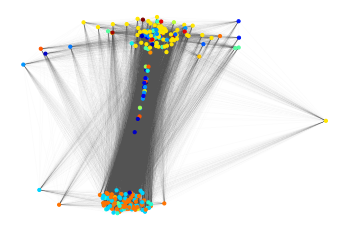

In [187]:
# create number for each group to allow use of colormap
from itertools import count
# get unique groups
grupos = set(nx.get_node_attributes(grafo,'party').values())
groups = set([gr.text for gr in list(grupos) ])
mapping = dict(zip((groups),count()))
nodes = grafo.nodes()
colors = [mapping[grafo.nodes[n]['party'].text] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(grafo)
ec = nx.draw_networkx_edges(grafo, pos, alpha=0.01)
nc = nx.draw_networkx_nodes(grafo, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=10, cmap=plt.cm.jet)

plt.axis('off')
plt.show()